<a href="https://colab.research.google.com/github/enzocatorano/deep_learning_practicas/blob/master/7_1_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Profundo FICH: Autocodificadores variacionales

Entrenando un autocodificador variacional en MNIST.

In [2]:
# Imports genericos
import sys
print("Versión de Python:", sys.version)

import numpy as np
from numpy.random import multivariate_normal
from matplotlib import pyplot as plt
import torch as tr
from torch import nn
from torch.nn import functional as F

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

Versión de Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


## Dataset
Usaremos el dataset de dígitos manuscritos MNIST


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.51MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 62.6kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.33MB/s]


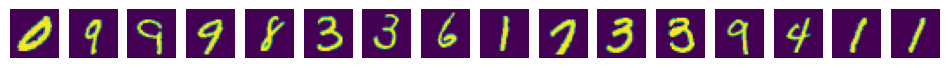

In [3]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

T = transforms.ToTensor()

train_data = MNIST("mnist-data", train=True,
                   transform=T, download=True)
test_data = MNIST("mnist-data", train=False,
                  transform=T, download=True)

nbatch = 128
train_loader = DataLoader(train_data, batch_size=nbatch, shuffle=True)

# Ejemplos de train
for x, y in train_loader:
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for k in range(16):
        ax[k].imshow(x[k,:,:].squeeze())
        ax[k].axis("off")
    break # solo un batch

imsize = train_data[0][0].shape[1:]

## Arquitectura

La siguiente celda define el VAE. Notar que es similar a lo visto en PixelAE. Los cambios están en la función de costo y la función de forward que usa el muestreo parametrizado.

In [ ]:
from typing import List
from tqdm.auto import tqdm

class PixelVAE(nn.Module):
    """Autocodificador variacional que toma como entrada y salida una imagen.
    Internamente se trata como un vector de píxeles concatenados."""

    # Constructor
    def __init__(self, input_shape: List[int], encoder_size: int,
                 latent_size: int, lr=1e-3, kl_beta=1, device="cpu"):
        super(PixelVAE, self).__init__()
        self.device = device

        self.imsize = input_shape
        input_size = input_shape[0] * input_shape[1]

        self.kl_beta = kl_beta


        self.encoder = nn.Sequential(*[nn.Linear(input_size, encoder_size),
                                       nn.Sigmoid()])

        # Parámetros que definen las distribuciones de probabilidad de la
        # familia Q(z|x), en este caso normales.
        self.mu = nn.Linear(encoder_size, latent_size)
        self.sigma = nn.Linear(encoder_size, latent_size)

        self.decoder = nn.Sequential(*[nn.Linear(latent_size, encoder_size),
                                       nn.Sigmoid(),
                                       nn.Linear(encoder_size, input_size),
                                       nn.Sigmoid()] )

        self.optimizer = tr.optim.Adam(self.parameters(), lr=lr)

        self.to(device)

    #    self.init()

    #def init(self):
    #    for layer in self.parameters():
    #        if isinstance(layer, nn.Linear):
    #            nn.init.kaiming_normal_(m.weight)
    #            nn.init.constant_(m.bias, 0.0)

    def encode(self, x):
        # Convierte imagen en vector
        x = self.flatten(x)
        # Pasa por el "encoder determinístico".
        x = self.encoder(x)
        # Genera los parámetros de la distribución de probabilidad (notar que
        # mu y sigma son combinaciones lineales de x)
        mu = self.mu(x)
        sigma = self.sigma(x)

        # También se podria haber codificado mu y sigma en la misma
        # capa oculta del encoder:
        # x = self.encoder(x)
        # mu = x[:x.shape[1]//2]
        # sigma = x[x.shape[1]//2:]

        # Muestreo
        sigma = 1e-6 + F.softplus(sigma) # Sigma tiene que ser positivo
        q = tr.distributions.Normal(mu, sigma)
        z = q.rsample()

        # that's it
        return z, mu, sigma


    def decode(self, z):
        # El decoder es completamente determinístico

        x_hat = self.decoder(z)

        # Vuelve a la forma de imagen
        x_hat = self.unflatten(x_hat)

        return x_hat

    def forward(self, x):

        # x -> encoder -> z (espacio latente)
        z, _, _ = self.encode(x)  # acá no usamos mu y sigma
        # z -> decoder -> x estimado
        x_hat = self.decode(z)

        return x_hat

    def flatten(self, x):
        nbatch = x.shape[0]
        x = x.view(nbatch, -1)
        return x

    def unflatten(self, x):
        nbatch = x.shape[0]
        x = x.view(nbatch, -1, self.imsize[0], self.imsize[1])
        return x


    def loss(self, x, z, x_hat, mu, sigma, use_kl):
        """Definición de función de perdida."""

        # Función de pérdida por reconstrucción
        rec_loss = F.mse_loss(x_hat, x)

        # Densidades del encoder y aproximada, ambas normales
        p_z = tr.distributions.Normal(tr.zeros_like(mu), tr.ones_like(sigma))
        q_z = tr.distributions.Normal(mu, sigma) # requiere sigma>0

        # Divergencia KL: Se obtienen las medidas de densidad para z y se toma
        # la diferencia.
        log_qz = q_z.log_prob(z)
        log_pz = p_z.log_prob(z)
        kl_loss = self.kl_beta * (log_qz - log_pz).mean()

        # Y combinamos las funciones de pérdida
        if use_kl:
            loss = kl_loss + rec_loss
        else:
            loss = rec_loss

        # devuelvo todo para graficar, sino solo usamos el loss combinado
        return loss, rec_loss, kl_loss

    def fit(self, x, use_kl):

        self.optimizer.zero_grad()

        z, mu, sigma = self.encode(x)

        x_hat = self.decode(z)

        loss, rec_loss, kl_loss = self.loss(x, z, x_hat, mu, sigma, use_kl)

        loss.backward()
        self.optimizer.step()

        return loss.item(), rec_loss.item(), kl_loss.item()

    def train(self, dataloader, nepochs, warming_epochs):

        loss_log, rec_loss_log, kl_loss_log = [], [], []
        print("Empieza entrenamiento...")
        epoch_iterator = tqdm(range(nepochs))
        for n in epoch_iterator:
            loss_batch, rec_loss_batch, kl_loss_batch = 0, 0 , 0
            for batch in dataloader: # se recorre el dataloader en batches

                # Si hay etiquetas (normalmente hay) las dejamos de lado
                if type(batch) == list:
                    batch = batch[0]

                if n < warming_epochs:
                    use_kl = False
                else:
                    use_kl = True

                l, lr, lk = self.fit(batch.to(self.device), use_kl)
                loss_batch += l
                rec_loss_batch += lr
                kl_loss_batch += lk

            loss_log.append(loss_batch/len(dataloader))
            rec_loss_log.append(rec_loss_batch/len(dataloader))
            kl_loss_log.append(kl_loss_batch/len(dataloader))

            epoch_iterator.set_postfix({'loss': loss_log[-1],
                                        'rec_loss': rec_loss_log[-1],
                                        'kl_loss_log': kl_loss_log[-1]})
        return loss_log, rec_loss_log, kl_loss_log


PixelVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): Sigmoid()
  )
  (mu): Linear(in_features=784, out_features=2, bias=True)
  (sigma): Linear(in_features=784, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=784, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=784, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Empieza entrenamiento...


  0%|          | 0/50 [00:00<?, ?it/s]

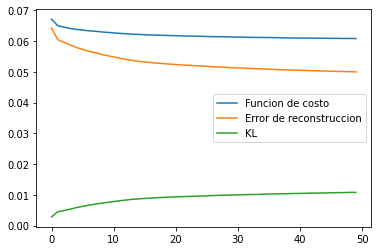

In [ ]:
# # Reproducibilidad
np.random.seed(1)
tr.manual_seed(1)

input_size = imsize[0] * imsize[1]
encoder_size =  input_size
latent_size = 2
net = PixelVAE(imsize, encoder_size, latent_size, kl_beta=.01, lr=1e-3,
               device="cuda")
print(net)
train_loss, rec_loss, kl_loss = net.train(train_loader, nepochs=50, warming_epochs=0)
plt.plot(train_loss, label="Funcion de costo")
plt.plot(rec_loss, label="Error de reconstruccion")
plt.plot(kl_loss, label="KL")
plt.legend()

Ejemplos de train


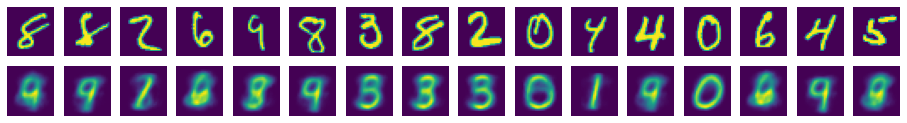

In [ ]:
# Reconstrucción

net = net.cpu()

print("Ejemplos de train")
for x, _ in train_loader:
    x_hat = net(x).detach()
    fig, ax = plt.subplots(2, 16, figsize=(16, 2))
    for k in range(16):
        ax[0, k].imshow(x[k,:,:].squeeze(), aspect="auto")
        ax[0, k].axis("off")

        ax[1, k].imshow(x_hat[k,:].view(28, 28), aspect="auto")
        ax[1, k].axis("off")
    break # solo un batch

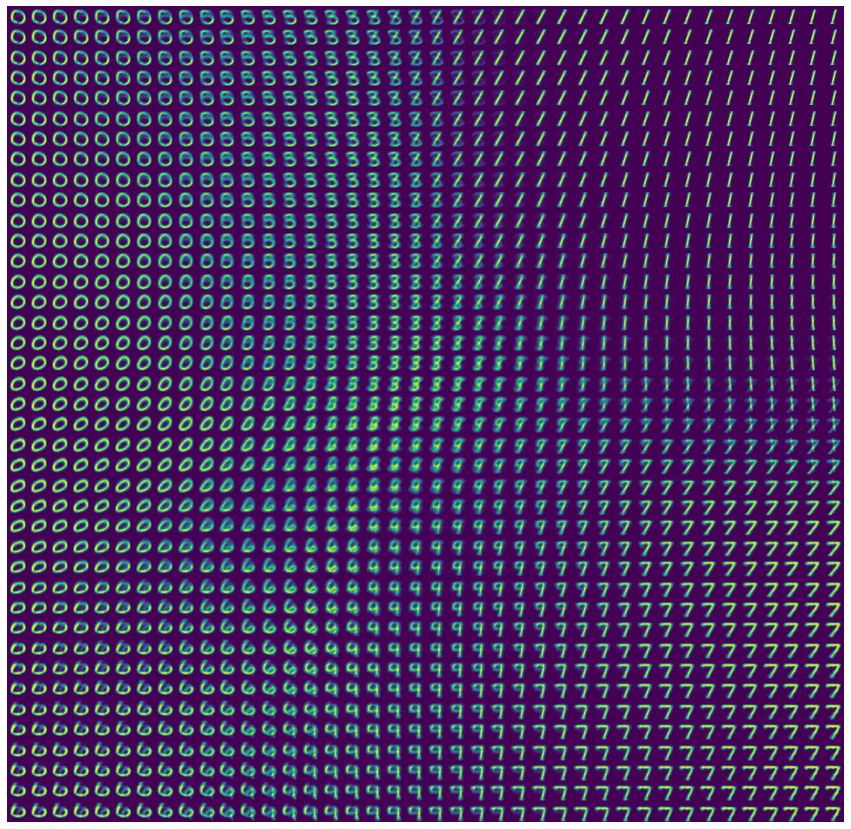

In [ ]:
# Recorriendo representacion

N = 40
fig, ax = plt.subplots(N, N, figsize=(15,15))
ax = ax.ravel()
n = 0
for x in np.linspace(-3, 3, N):
    for y in np.linspace(-3, 3, N):
        z = tr.tensor([x, y]).unsqueeze(0).float()
        x_gen = net.decode(z).detach().squeeze()
        ax[n].imshow(x_gen, aspect="auto")
        ax[n].axis("off")
        n += 1

plt.subplots_adjust(wspace=0, hspace=0)


# Visualización del espacio en z

In [ ]:
# Z para test
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
test_z = np.zeros((len(test_loader), latent_size), dtype=float)
test_labels = np.zeros(len(test_loader), dtype=int)
for k, (x, y) in enumerate(test_loader):
    z, _, _ = net.encode(x)
    z = np.array(z.detach().squeeze())
    test_z[k, :] = z
    test_labels[k] = int(y.squeeze())

# Ordenamos los ejemplos por dígito
ind = np.argsort(test_labels)

test_labels = test_labels[ind]
test_z = test_z[ind, :]


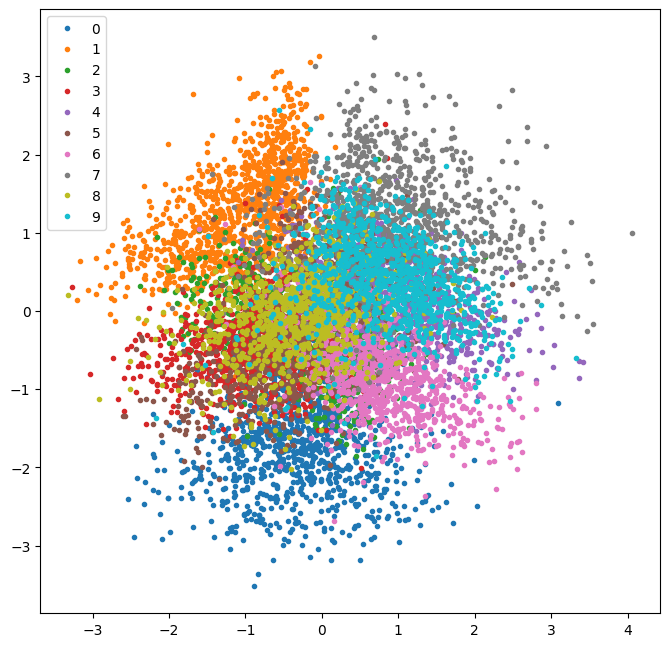

In [ ]:
plt.rcParams['figure.dpi'] = 100

plt.figure(figsize=(8, 8))
for k, l in enumerate(np.unique(test_labels)):
    ind = test_labels == l
    markersize = 3

    plt.plot(test_z[ind, 0], test_z[ind, 1], "o", label=l, markersize=markersize)

plt.legend();